**Zipper: convnet and lstm**
---
Companion notebooks from the article https://medium.com/p/83eb78f9963e/edit.

There are 3 parts:
- [part1](https://www.kaggle.com/blocks/zipper-putting-it-all-together-part-1): data exploration and preprocessing
- [part2](https://www.kaggle.com/blocks/zipper-putting-it-all-together-part-2): classification with gradient boosting (and autotuning)
- [part3](https://www.kaggle.com/blocks/zipper-putting-it-all-together-part-3): convnet and lstm

You can also find the capture app for iOS at https://github.com/jeanfredericplante/lowflyer

---

In [1]:
import numpy as np
import pandas as pd
import fastai
import math
import datetime
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
from tqdm import tqdm, tqdm_notebook
import plotly.graph_objs as go

In [2]:
df_all = pd.read_pickle('../input/df_all_norm.pkl') 
size_per_batch = pd.read_pickle('../input/size_per_batch.pkl')

In [3]:
size_per_batch.head(3)

,length,open,walking
batch,,,
0,1160,1,1
1,3002,1,1
2,1743,1,1


## Utility functions

In [4]:
def select_train_test_batches(size_per_batch, label = "walking",percent = 0.2):
    target = label # "is_open"
    # target = "open"
    percent_test = percent
    size_per_batch= size_per_batch.reset_index().set_index([target,'batch']).sort_index()
    target_per_class = size_per_batch.groupby(target).sum()*percent_test
    test_batches = []
    target_length = 0
    while target_length < target_per_class.iloc[0].length:
        sample_batch = size_per_batch.xs(0).sample()
        target_length += sample_batch.length.values[0]
        test_batches.append(sample_batch.index.values[0])
    target_length = 0
    while target_length < target_per_class.iloc[1].length:
        sample_batch = size_per_batch.xs(1).sample()
        target_length += sample_batch.length.values[0]
        test_batches.append(sample_batch.index.values[0])
    train_batches = size_per_batch.index.levels[1].values
    train_batches = set(train_batches) - set(test_batches)
    print(f"train batch:{train_batches}, test batches {test_batches}")
    return train_batches,test_batches

### A bit of feature engineering
def create_training_with_fft(window_size = 128, step_size = 10, batch_list=[],
                             features=["aa","ax","ay","az"], fft_only=False, 
                             remove_0_freq=True, add_fft=True, get_batchlist = False,
                             return_neg_freq = True, flatten = False):
    x = [] ; y = [] ; blist = []
    if not batch_list: batch_list = df_all.batch.unique()
    for batch in batch_list:
        dftmp = df_all[df_all.batch==batch]
        for i in range(0, dftmp.ma.size-window_size,step_size):
            dfsub = dftmp.iloc[i:i+window_size]
            feat_val=dfsub[features].values
            if remove_0_freq:
                feat_val_fft = (dfsub - dfsub.mean())[features].values
            else:
                feat_val_fft = feat_val
            n = len(feat_val_fft)
            fft_feat_val = abs(np.fft.fft(feat_val_fft.T)/n).T    
            if not return_neg_freq:
                fft_feat_val = fft_feat_val[np.arange(n/2,dtype=int)] 
            if add_fft:
                if fft_only:
                    if flatten: x.append(fft_feat_val.T.flatten())
                    else: x.append(fft_feat_val.T)
                else:
                    if flatten:x.append(np.hstack((feat_val.T.flatten(), fft_feat_val.T.flatten())))
                    else: x.append(np.vstack((feat_val.T, fft_feat_val.T)))
            else:
                if flatten: x.append(feat_val.T.flatten())
                else: x.append(feat_val.T)
            y.append(dfsub[target].values[0])
            blist.append(batch)
    if get_batchlist: return np.array(x),np.array(y),blist
    else: return np.array(x),np.array(y)

from sklearn.metrics import roc_curve, recall_score, precision_score
def get_precision_recall(X,y,m):
    return  precision_score(y,m.predict(X)),recall_score(y,m.predict(X))

import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score, recall_score
# recall for zipper open is maximize rate of detection the flyer is open (minimize false negatives).
# recall: real->detected max, precision: detected -> real max (minimize false positives)

def plot_confusion_matrix(Y_true, Y_pred, label="walking",ax=[]):
    cm = confusion_matrix( Y_true, Y_pred)
    prec= precision_score(Y_true, Y_pred)
    rec = recall_score(Y_true,Y_pred)
    if label is "walking":
        labels = ["still","walking"]
    else:
        labels = ["close","open"]
    cm_df = pd.DataFrame(cm,index = labels, columns = labels)
    sns.heatmap(cm_df, annot=True,ax=ax)
    ax.set_title(f'Confusion Matrix, prec {prec:.2f} - recall {rec:.2f}')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Convolutional network

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdatautils

from fastai.basic_data import DataBunch, DatasetType
from fastai.basic_train import Learner
from fastai.train import *
from fastai import *

import pdb

In [6]:
class ZipNet(nn.Module):
    ## input channel 128x1
    def __init__(self, ks = 5, ws = 128, feature_size = 6):
        # ws: Window size, which is the time series input size
        # feature_size: 6 (number of channels)
        # features already ordered by by features first and fft last
        # ks: kernel_size
        # kernel_size: conv size
        # 128 -> 128 - ks + 1 = 124*6 -> 
        
        
        super(ZipNet,self).__init__()
        num_conv = 3; 
        num_layer_conv = 72 #36
        num_fc = 30; 
        self.flat_conv_size = ws
        self.feature_size = feature_size
        for i in range(num_conv):
            self.flat_conv_size = (self.flat_conv_size - ks + 1)/2
        self.flat_conv_size = int(self.flat_conv_size)*num_layer_conv
        self.flat_fft_size = ws * (feature_size // 2) 
        self.conv1 = nn.Conv1d(feature_size // 2,num_layer_conv,ks)
        self.bn1 = nn.BatchNorm1d(num_layer_conv)
        self.conv2 = nn.Conv1d(num_layer_conv,num_layer_conv,ks)
        self.bn2 = nn.BatchNorm1d(num_layer_conv)
        self.conv3 = nn.Conv1d(num_layer_conv,num_layer_conv,ks)
        self.fc1 = nn.Linear(self.flat_conv_size + self.flat_fft_size,num_fc)
        self.bn3 = nn.BatchNorm1d(num_fc)
        self.fc2 = nn.Linear(num_fc,1)


    def forward(self, x):
        # input is batch, [feats,fft_feats], samples
        idx_feat = np.arange(self.feature_size // 2)
        idx_fft = self.feature_size // 2 + np.arange(self.feature_size // 2)
        x_feat  = x[:,idx_feat,:]; x_fft = x[:,idx_fft,:]
        # Conv on features
        xf = self.conv1(x_feat) # 128 -> 124
        xf = F.max_pool1d(F.relu(xf), 2) # 124 -> 62
        xf = self.conv2(xf) # 62 -> 58
        xf = F.max_pool1d(F.relu(xf), 2) # 58 -> 29
        xf = self.conv3(xf) # 29 -> 25
        xf = F.max_pool1d(F.relu(xf), 2) # 58 -> 29

        # Flatten and fully connected
        xf = xf.view(-1,self.flat_conv_size)
        xfft= x_fft.view(-1, self.flat_fft_size)
        x = torch.cat((xf, xfft), 1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x).squeeze())
        return x

### data processing

In [7]:
target = "open"
train_batches,test_batches = select_train_test_batches(size_per_batch[size_per_batch.walking==1],label = target, percent = 0.2)

train batch:{0, 1, 2, 5, 6, 9, 12, 18, 19, 20, 21, 22, 23, 27, 29, 30, 33, 34, 35, 36, 39, 40, 41, 43, 44, 46, 47, 50, 51, 53, 54, 55, 56}, test batches [13, 49, 45, 38, 10, 11, 11, 17]


In [8]:
# Reusing same batches as for LGBM to compare performance
train_batches = {0, 1, 2, 5, 6, 9, 11, 12, 13, 17, 18, 19, 20, 21, 23, 27, 30, 33, 35, 39, 41, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56}
test_batches = [38, 34, 36, 22, 29, 40, 10]

In [9]:
features = ["mx","my","mz","ax","ay","az"];
ws = 128; fft_only = False;  remove_0freq = True
# X_trn sample, feature, time
X_trn,Y_trn, blist_trn = create_training_with_fft(batch_list=train_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True)
X_val,Y_val, blist_val = create_training_with_fft(batch_list=test_batches,features=features, window_size=ws, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True)

In [10]:
train_ds = tdatautils.TensorDataset(torch.from_numpy(X_trn).to(torch.float32),torch.from_numpy(Y_trn).to(torch.float32))
valid_ds = tdatautils.TensorDataset(torch.from_numpy(X_val).to(torch.float32),torch.from_numpy(Y_val).to(torch.float32))

In [11]:
batch_size = 16
model_data = DataBunch.create(train_ds,valid_ds, valid_ds, bs=batch_size) # fastai library's Databunch

### creating and validating the model

In [12]:
zipnet = ZipNet(ks=5, feature_size=12)

In [13]:
zipnet(model_data.one_batch(DatasetType.Train)[0])

tensor([0.4731, 0.4714, 0.4704, 0.4707, 0.4688, 0.4707, 0.4703, 0.4701, 0.4706,
        0.4732, 0.4700, 0.4692, 0.4712, 0.4703, 0.4721, 0.4678],
       grad_fn=<SigmoidBackward>)

In [14]:
ziplearner = Learner(model_data, zipnet, opt_func=torch.optim.Adam, loss_func=F.binary_cross_entropy)  # fastai's library Learner

In [15]:
ziplearner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


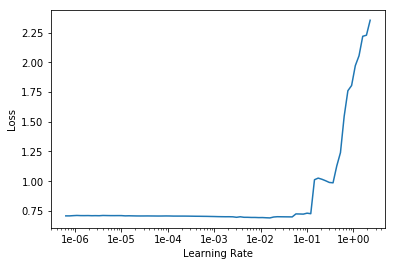

In [16]:
ziplearner.recorder.plot()

In [17]:
ziplearner.fit_one_cycle(20,1e-2,wd=1e-2)

epoch,train_loss,valid_loss,time
0,0.329684,0.176933,00:02
1,0.160903,0.310103,00:02
2,0.157186,0.643500,00:02
3,0.180088,0.261207,00:02
4,0.160246,0.323058,00:02
5,0.174042,0.197147,00:02
6,0.140392,0.241055,00:02
7,0.144156,0.434747,00:02
8,0.059566,0.514765,00:02
9,0.063251,0.599349,00:02


In [18]:
res_trn = ziplearner.get_preds(ds_type=DatasetType.Train)
res_val = ziplearner.get_preds(ds_type=DatasetType.Valid)
trn_pred = res_trn[0].numpy() > 0.5
trn_target = res_trn[1].numpy()
val_pred = res_val[0].numpy() > 0.5
val_target = res_val[1].numpy()

Text(0.5, 1.0, 'Validation: Confusion Matrix, prec 0.97 - recall 0.75')

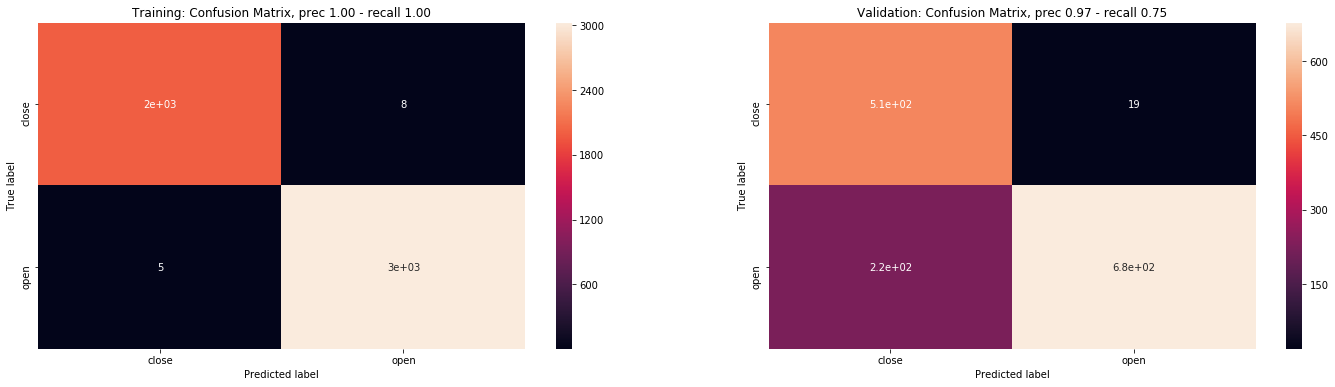

In [19]:
fig,axes = plt.subplots(1,2,figsize=(24,6))
plot_confusion_matrix(trn_target,trn_pred,label="open",ax=axes[0]);axes[0].set_title("Training: " + axes[0].get_title())
plot_confusion_matrix(val_target,val_pred,label="open",ax=axes[1]);axes[1].set_title("Validation: " + axes[1].get_title())

# LSTM

In [20]:
class ReZipNet(nn.Module):
    ## input channel wsx3
    def __init__(self, num_layers = 10, hidden_dim = 5, fs = 128, dropout=0.2):
        # fs: feature size
        super(ReZipNet,self).__init__()
        self.lstm = nn.LSTM(fs, hidden_dim, num_layers=num_layers,dropout=dropout)
        self.hidden2prob = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self,x):
        lstm_out, _ = self.lstm(x.view(len(x), 1, -1))
        lstm_out = self.dropout(lstm_out)
        y = self.hidden2prob(lstm_out.view(len(x), -1))
        y = torch.sigmoid(y).squeeze()
        return y


### Reformat our training data for input to LSTM

In [21]:
# features = ["mx","my","mz","ax","ay","az"];
features = ["mx","my","mz"];
ws = 128; fft_only = False;  remove_0freq = True; add_fft= True
# X_trn sample, feature, time
X_trn,Y_trn, blist_trn = create_training_with_fft(batch_list=train_batches,features=features, window_size=ws, add_fft = add_fft, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True)
X_val,Y_val, blist_val = create_training_with_fft(batch_list=test_batches,features=features, window_size=ws, add_fft = add_fft, fft_only=fft_only, remove_0_freq=remove_0freq, get_batchlist=True)


X_trn = X_trn.reshape(X_trn.shape[0],1,-1)
X_val = X_val.reshape(X_val.shape[0],1,-1)

In [22]:
train_ds = tdatautils.TensorDataset(torch.from_numpy(X_trn).to(torch.float32),torch.from_numpy(Y_trn).to(torch.float32))
valid_ds = tdatautils.TensorDataset(torch.from_numpy(X_val).to(torch.float32),torch.from_numpy(Y_val).to(torch.float32))

In [23]:
batch_size = 8
model_data = DataBunch.create(train_ds,valid_ds, valid_ds, bs=batch_size) # fastai library's Databunch
X_trn[0].shape[1]

768

In [24]:
nfeat = X_trn[0].shape[1]
zipnet = ReZipNet(num_layers=2, hidden_dim=100, fs = nfeat, dropout=0.3)

In [25]:
ziplearner = Learner(model_data, zipnet, opt_func=torch.optim.Adam, loss_func=F.binary_cross_entropy)

In [26]:
ziplearner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


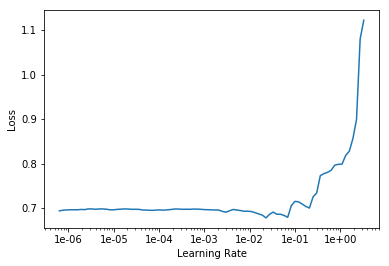

In [27]:
ziplearner.recorder.plot()


In [28]:
ziplearner.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,time
0,0.637760,0.757403,00:03
1,0.574138,0.842493,00:03
2,0.441536,1.280970,00:04
3,0.440292,1.053160,00:04
4,0.400682,1.003716,00:04
5,0.372130,0.888471,00:03
6,0.395833,0.791071,00:03
7,0.338797,1.014406,00:03
8,0.303763,0.909336,00:03
9,0.305610,1.051409,00:03


In [29]:
res_trn = ziplearner.get_preds(ds_type=DatasetType.Train)
res_val = ziplearner.get_preds(ds_type=DatasetType.Valid)
trn_pred = res_trn[0].numpy() > 0.5
trn_target = res_trn[1].numpy()
val_pred = res_val[0].numpy() > 0.5
val_target = res_val[1].numpy()

Text(0.5, 1.0, 'Validation: Confusion Matrix, prec 0.70 - recall 0.77')

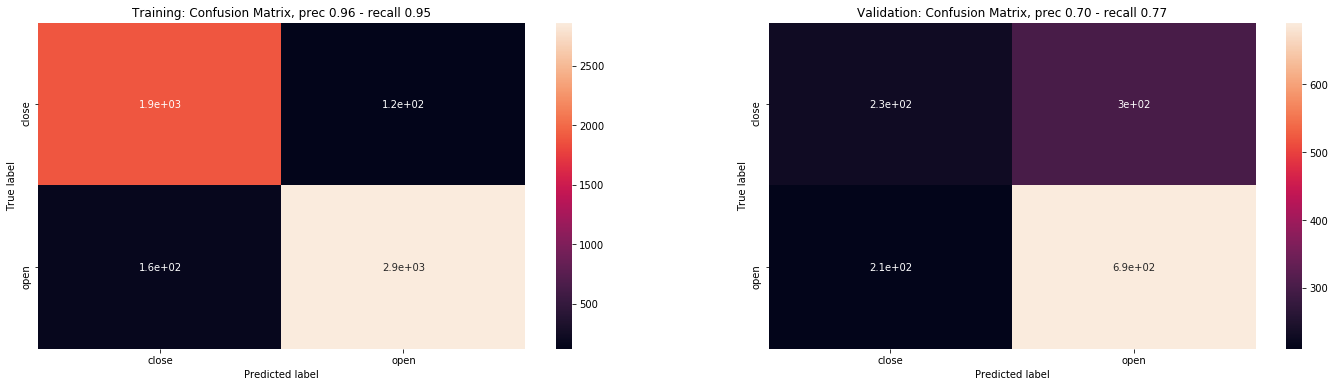

In [30]:
fig,axes = plt.subplots(1,2,figsize=(24,6))
plot_confusion_matrix(trn_target,trn_pred,label="open",ax=axes[0]);axes[0].set_title("Training: " + axes[0].get_title())
plot_confusion_matrix(val_target,val_pred,label="open",ax=axes[1]);axes[1].set_title("Validation: " + axes[1].get_title())